# Import Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Load Data

In [4]:
root_dir = "dataset/"

In [5]:
image_paths = os.listdir(root_dir)
len(image_paths)

100

In [6]:
images = []

for image_path in image_paths:
    img = load_img(root_dir + image_path, target_size=(64, 64), color_mode="grayscale")
    img = img_to_array(img)
    img = img / 255.
    images.append(img)

In [7]:
images = np.array(images)

In [8]:
type(images)

numpy.ndarray

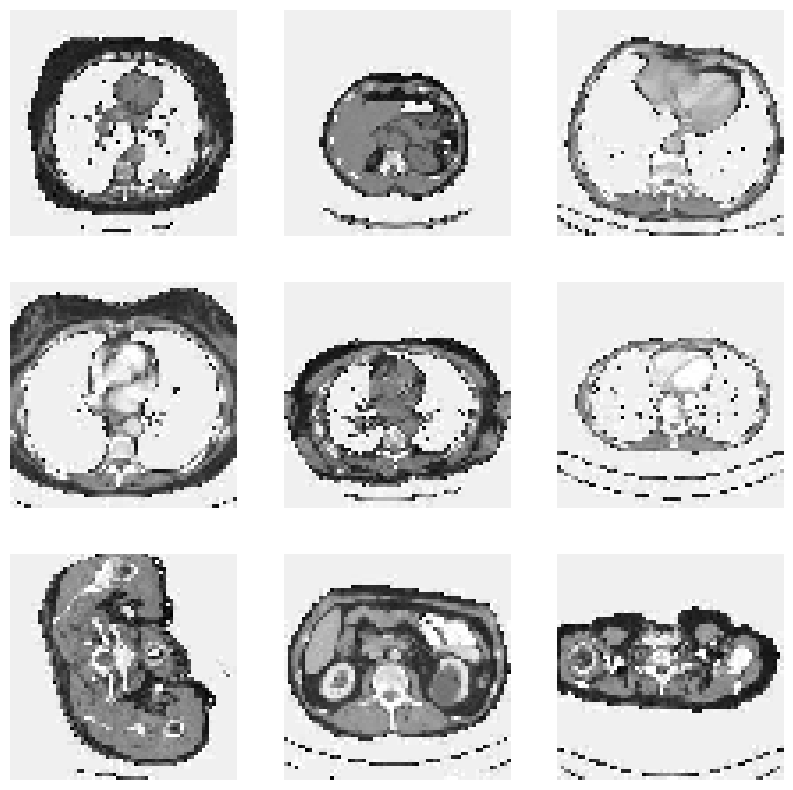

In [9]:
# plot some images

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()


# Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []

for img in images:
    img = img.reshape((1, 64, 64, 1))
    for _ in range(5):  # generate 5 augmentations per image
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            break

augmented_images = np.array(augmented_images)
print(f"Nombre d'images augmentées : {len(augmented_images)}")


Nombre d'images augmentées : 500


In [11]:
images = np.concatenate([images, augmented_images])

In [12]:
noise_factor = 0.2

noise_images = []

for image in images:
    noisy = image + noise_factor * np.random.randn(*image.shape) #We generate random Gaussian noise (normal distribution) with the same shape as the image 64 *64.
    noisy = np.clip(noisy, 0., 1.)  #standardization
    noise_images.append(noisy)

np.clip(noisy, 0., 1.) limits (or "clips") the values of the noisy image array.
If any value in the noisy array is less than 0., it will be set to 0..
If any value in the noisy array is greater than 1., it will be set to 1..

In [13]:
noise_images = np.array(noise_images)

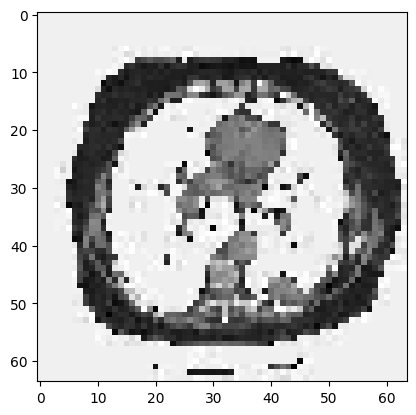

In [14]:
plt.imshow(images[0], cmap="gray")

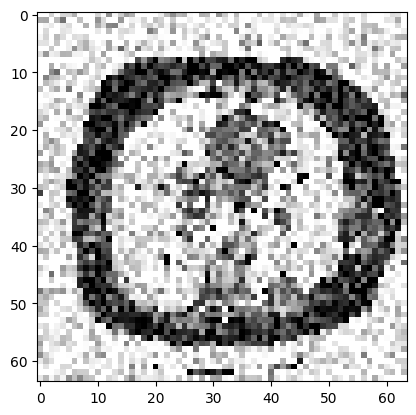

In [15]:
plt.imshow(noise_images[0], cmap="gray")

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
noise_images = np.array(noise_images)

# Split data into train/test (e.g. 80% train, 20% test)
normal_train, normal_test, noise_train, noise_test = train_test_split(
    images, noise_images, test_size=0.2, random_state=42
)

print("normal_train:", normal_train.shape)
print("normal_test:", normal_test.shape)
print("noise_train:", noise_train.shape)
print("noise_test:", noise_test.shape)


normal_train: (480, 64, 64, 1)
normal_test: (120, 64, 64, 1)
noise_train: (480, 64, 64, 1)
noise_test: (120, 64, 64, 1)


# Models

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

In [19]:
def autoencoder():

    input_img = Input(shape=(64,64,1), name='image_input')

    #enoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)   #32

    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [20]:
model= autoencoder()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample1 (UpSampling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample2 (UpSampling2D)        │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 64, 64, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(noise_train,
                 normal_train,
                 validation_data=(noise_test, normal_test),
                 epochs=50,
                 batch_size=16)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.5771 - val_loss: 0.4563
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4520 - val_loss: 0.4355
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4293 - val_loss: 0.4276
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4197 - val_loss: 0.4256
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4160 - val_loss: 0.4215
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4143 - val_loss: 0.4196
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4144 - val_loss: 0.4177
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4120 - val_loss: 0.4166
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4128 - val_loss: 0.4162
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4117 - val_loss: 0.4157
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4121 - val_loss: 0.4145
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4097 - val_l

In [22]:
# Sauvegarde du modèle complet (architecture + poids + compile info)
model.save("autoencoder_brain_tumor.h5")

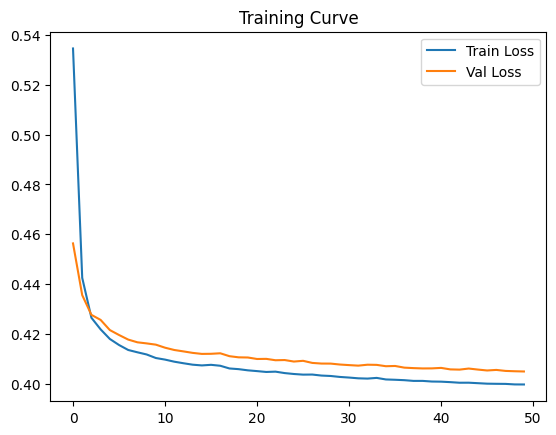

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Curve")
plt.show()


In [25]:
predicted = model.predict(noise_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step


In [26]:
from sklearn.metrics import mean_squared_error
# Calculate Mean Squared Error (MSE)
actual_values_flat = normal_test.flatten()
predicted_values_flat = predicted.flatten()

mse = mean_squared_error(actual_values_flat, predicted_values_flat)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.010648035444319248


In [27]:
evaluation = model.evaluate(noise_test, normal_test)
evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.4066


0.4049133360385895

In [29]:
def plot_predictions(test, preds):
    plt.figure(figsize=(12, 6))

    # Noise test
    for i in range(16):
        plt.subplot(4, 8, i + 1)
        plt.imshow(test[i], cmap='gray')
        plt.axis('off')
        plt.title('Noised')

    # Predicted
    for i in range(16):
        plt.subplot(4, 8, i + 17)
        plt.imshow(preds[i], cmap='gray')
        plt.axis('off')
        plt.title('Predicted')

    plt.show()

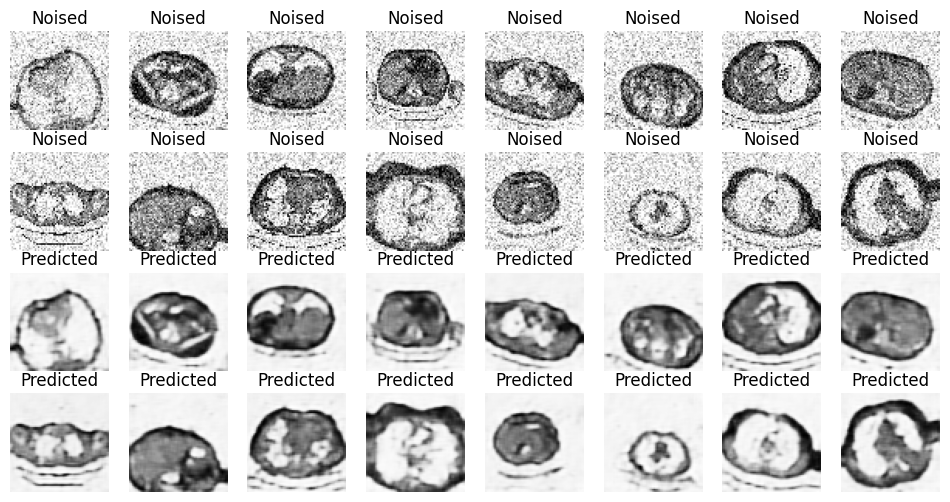

In [30]:
plot_predictions(noise_test, predicted)

In [31]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

# Calculate PSNR for each pair of clean and denoised images and take the absolute value
psnr_values = [abs(peak_signal_noise_ratio(clean_img, denoised_img, data_range=denoised_img.max() - denoised_img.min())) for clean_img, denoised_img in zip(normal_test, predicted)]

# Calculate the average PSNR
average_psnr = np.mean(psnr_values)

# Print the average PSNR
print("Average PSNR:", average_psnr)


Average PSNR: 18.80031690898376


**PSNR (Peak Signal-to-Noise Ratio)** measures the quality of a denoised image by comparing it to the original clean image. A higher PSNR indicates better image quality (less difference from the original), while a lower PSNR suggests more distortion.

In [74]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():

    input_img = Input(shape=(64,64,1), name='image_input')

    #enoder
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)   #32

    #decoder
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

    #model
    autoencoder = Model(inputs=input_img, outputs=x)

    return autoencoder

In [75]:
autoencoder2= autoencoder()
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')

In [76]:
history2=autoencoder2.fit(noise_train,
                 normal_train, epochs=70, batch_size=16, shuffle=True, validation_data=(noise_test, normal_test))

Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0681 - val_loss: 0.0260
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0231 - val_loss: 0.0189
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0180 - val_loss: 0.0164
Epoch 4/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 5/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 6/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 7/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 8/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - val_loss: 0.0123
Epoch 9/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 10/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 11/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 12/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0

In [77]:
# Sauvegarde du modèle complet (architecture + poids + compile info)
autoencoder2.save("autoencoder_brain_tumor2.h5")

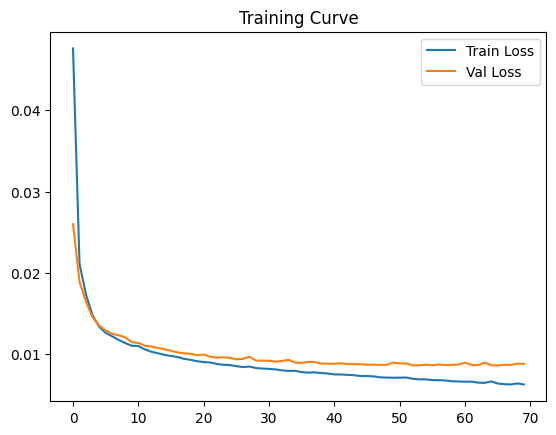

In [78]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Curve")
plt.show()

In [79]:
autoencoder2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 64, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample1 (UpSampling2D)        │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample2 (UpSampling2D)        │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 64, 64, 1)      │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,325,317 (20.31 MB)

 Trainable params: 1,775,105 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,550,212 (13.54 MB)

In [80]:
predicted = autoencoder2.predict(noise_test)

1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step


In [81]:
evaluation = autoencoder2.evaluate(noise_test, normal_test)
evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0088


0.00879997480660677

In [82]:
from sklearn.metrics import mean_squared_error
# Calculate Mean Squared Error (MSE)
actual_values_flat = normal_test.flatten()
predicted_values_flat = predicted.flatten()

mse = mean_squared_error(actual_values_flat, predicted_values_flat)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.00879997480660677


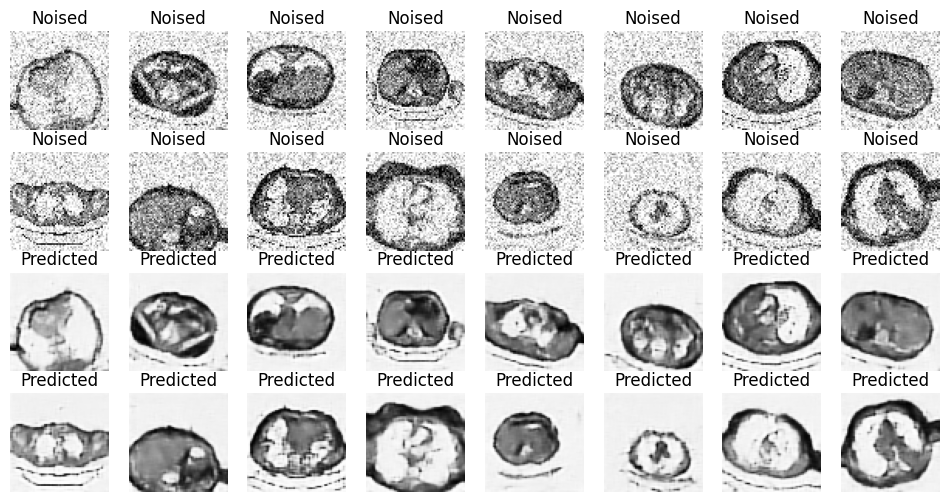

In [83]:
plot_predictions(noise_test, predicted)

In [84]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

# Assuming clean_images and denoised_images are numpy arrays containing the clean and denoised grayscale images respectively

# Calculate PSNR for each pair of clean and denoised images and take the absolute value
psnr_values = [abs(peak_signal_noise_ratio(clean_img, denoised_img, data_range=denoised_img.max() - denoised_img.min())) for clean_img, denoised_img in zip(normal_test, predicted)]

# Calculate the average PSNR
average_psnr = np.mean(psnr_values)

# Print the average PSNR
print("Average PSNR:", average_psnr)


Average PSNR: 19.94771818346712
